/tmp/ipykernel_19/2275411868.py:107: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_19/2275411868.py:110: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  -5.674967
1  Spectrum_1   -0.998045  Full_Spectrum  -5.596982
2  Spectrum_1   -0.996090  Full_Spectrum  -5.412705
3  Spectrum_1   -0.994135  Full_Spectrum  -5.456101
4  Spectrum_1   -0.992180  Full_Spectrum  -5.604399


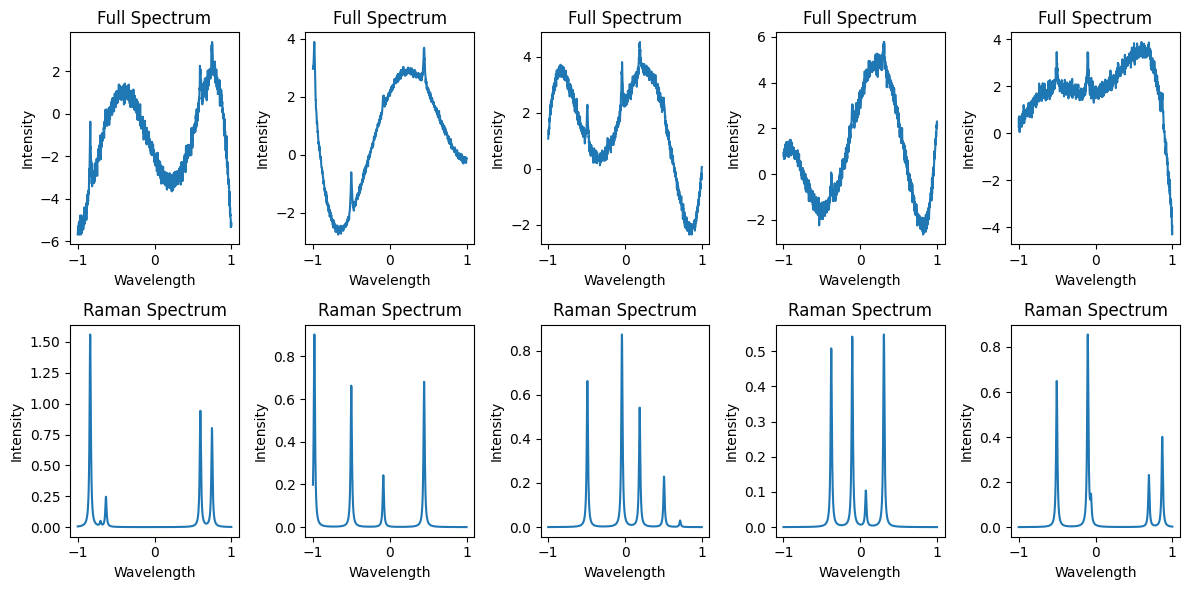

In [1]:
# SYNTHETIC SPECTRA, GOOD DATA STRUCTURE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Generate Cosmic Rays 
    # Lorentzian peak with a width of 0, y = 1 / (x - position)^2  
    # Cosmic ray amplitudes: randomized between 0.8 & L2-norm of complete signal

    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 5
    num_cosmic_rays = np.random.randint(1, 5)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Visualize results
plt.figure(figsize=(12, 6))

num_plots = min(5, num_spectra)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title('Full Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot corrected spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + num_plots + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i])
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()

/tmp/ipykernel_19/3192035222.py:107: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_19/3192035222.py:110: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   7.100589
1  Spectrum_1   -0.998045  Full_Spectrum   7.035729
2  Spectrum_1   -0.996090  Full_Spectrum   6.736937
3  Spectrum_1   -0.994135  Full_Spectrum   6.536030
4  Spectrum_1   -0.992180  Full_Spectrum   6.663419


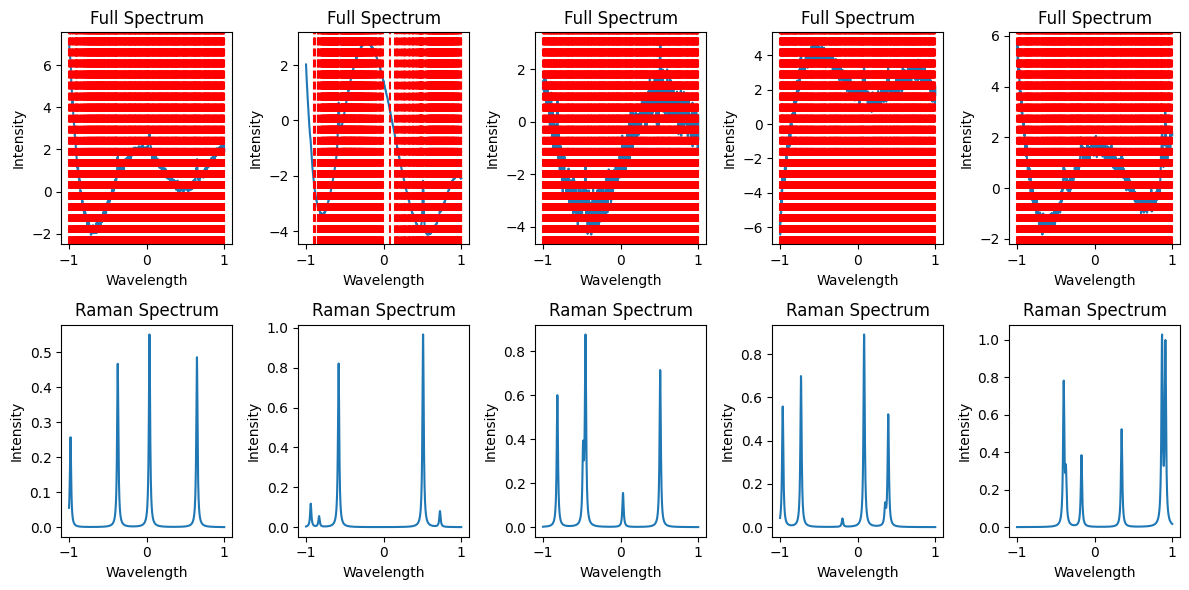

In [2]:
# SYNTHETIC SPECTRA, GOOD DATA STRUCTURE (part2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Generate Cosmic Rays 
    # Lorentzian peak with a width of 0, y = 1 / (x - position)^2  
    # Cosmic ray amplitudes: randomized between 0.8 & L2-norm of complete signal

    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 5
    num_cosmic_rays = np.random.randint(1, 5)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Visualize results
plt.figure(figsize=(12, 6))

num_plots = min(5, num_spectra)

# Plot full synthetic spectra with cosmic rays marked
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title('Full Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

    # Mark cosmic ray positions with vertical lines
    cosmic_ray_indices = np.where(np.diff(synthetic_data_generator.full_spectra_list[i]) > 0)[0]
    cosmic_ray_wavelengths = synthetic_data_generator.wavelengths[cosmic_ray_indices]

    for cosmic_ray_wavelength in cosmic_ray_wavelengths:
        plt.axvline(x=cosmic_ray_wavelength, color='red', linestyle='--', label='Cosmic Rays')

# Plot corrected spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + num_plots + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i])
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()

Cosmic Ray Indices: [   2    4    6 ... 5109 5111 5114]
Cosmic Ray Indices: [   2   10   14 ... 5109 5111 5114]
Cosmic Ray Indices: [   2   10   14 ... 5109 5111 5114]
Cosmic Ray Indices: [   2   10   14 ... 5109 5111 5114]
Cosmic Ray Indices: [   2   10   14 ... 5109 5111 5114]


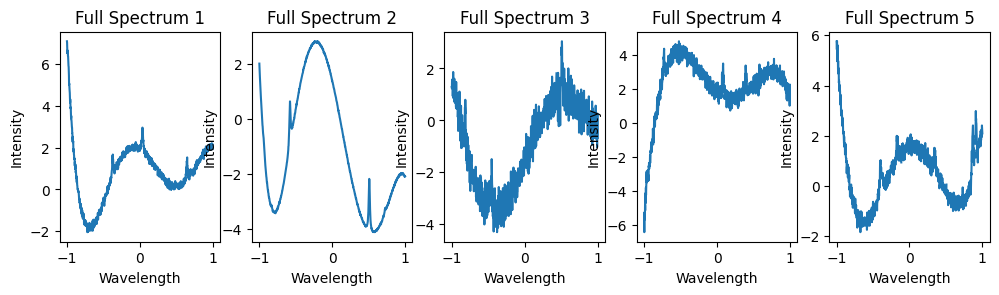

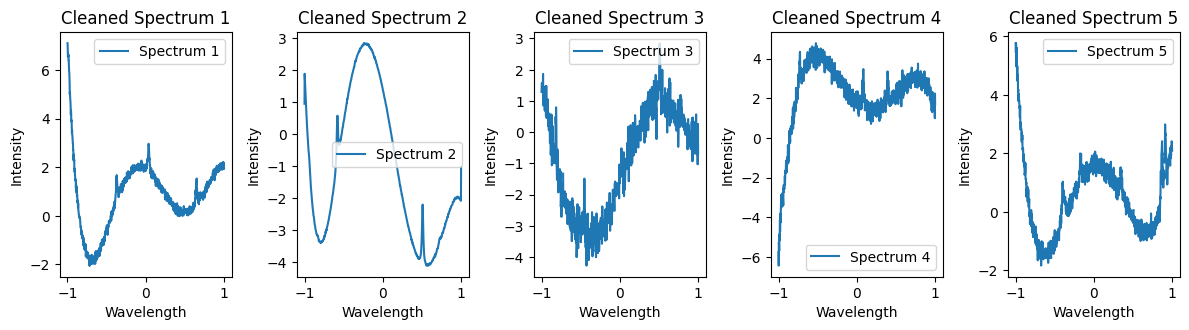

Value at index 2: 0.24291600552991444
Value at index 10: 0.10814484369623134
Value at index 14: 0.3934299605526439
Value at index 21: 0.3921008128060901
Value at index 24: 0.2680999650750757


In [3]:
# CLEAN RAYS (threshold value: 0.2)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if spectrum exists in the data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(data[data['Intensity_Type'] == 'Full_Spectrum']['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.1
        cosmic_ray_indices = np.where(second_difference > threshold)[0]
        
        # Print or inspect cosmic_ray_indices array
        print("Cosmic Ray Indices:", cosmic_ray_indices)

        # 3) Replace these points using linear interpolation from neighboring data points
        for index in cosmic_ray_indices:
            if index - 1 >= 0 and index + 1 < len(data):  # index must be within a valid range
                left_neighbor = data.at[index - 1, 'Intensity']
                right_neighbor = data.at[index + 1, 'Intensity']

                # Linear interpolation to replace cosmic ray spike
                interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                data.at[index, 'Intensity'] = interpolated_value
                         
        # Drop duplicate entries in 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append cleaned spectrum to list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Values at some cosmic ray indices
for index in cosmic_ray_indices[:5]:
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices: [   1    2    4 ... 5111 5114 5116]
Cosmic Ray Indices: [   2   10   14 ... 5111 5114 5116]
Cosmic Ray Indices: [   2   10   14 ... 5111 5114 5116]
Cosmic Ray Indices: [   2   10   14 ... 5111 5114 5116]
Cosmic Ray Indices: [   2   10   14 ... 5111 5114 5116]


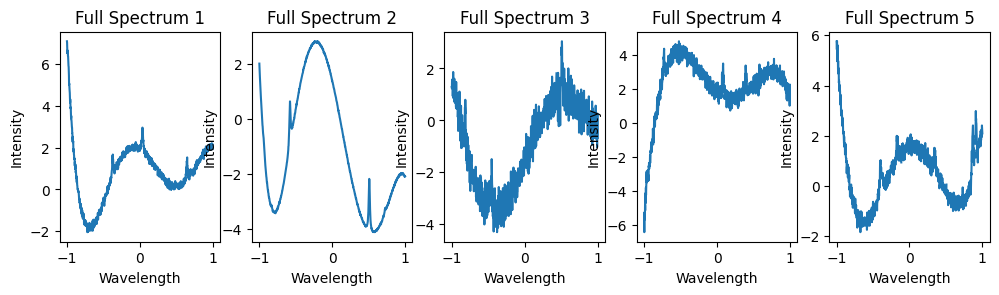

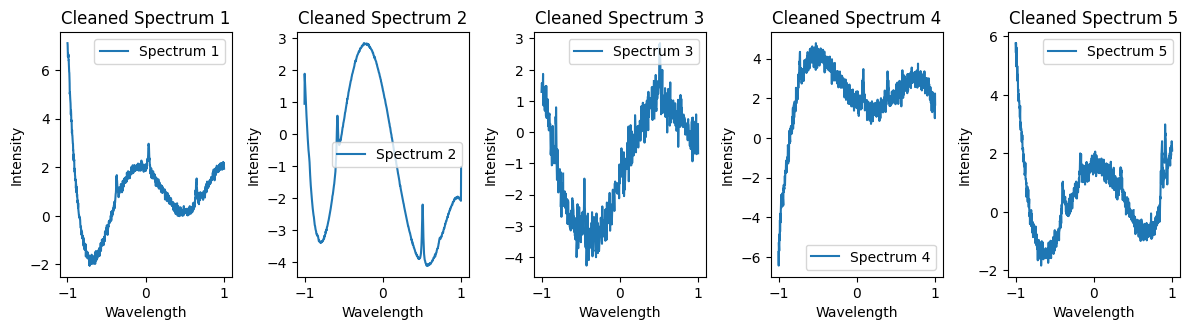

Value at index 2: 0.18443278315172762
Value at index 10: 0.01504613045470915
Value at index 14: 0.27626835863810406
Value at index 21: 0.3921008128060901
Value at index 24: 0.2680999650750757


In [4]:
# CLEAN RAYS (threshold value: 0.01)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if spectrum exists in the data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(data[data['Intensity_Type'] == 'Full_Spectrum']['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.01
        cosmic_ray_indices = np.where(second_difference > threshold)[0]
        
        # Print or inspect cosmic_ray_indices array
        print("Cosmic Ray Indices:", cosmic_ray_indices)

        # 3) Replace these points using linear interpolation from neighboring data points
        for index in cosmic_ray_indices:
            if index - 1 >= 0 and index + 1 < len(data):  # index must be within a valid range
                left_neighbor = data.at[index - 1, 'Intensity']
                right_neighbor = data.at[index + 1, 'Intensity']

                # Linear interpolation to replace cosmic ray spike
                interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                data.at[index, 'Intensity'] = interpolated_value
                         
        # Drop duplicate entries in 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append cleaned spectrum to list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()

# Values at some cosmic ray indices
for index in cosmic_ray_indices[:5]:
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices for Spectrum 1: [   1    2    4    6    8   10   12   14   16   17   21   24   28   30
   33   34   36   39   42   44   46   48   50   52   54   56   57   61
   63   65   67   68   70   71   73   74   76   77   80   83   85   86
   88   91   93   95   97   99  102  104  105  107  109  110  114  115
  116  119  121  123  127  129  132  134  137  139  140  143  145  148
  151  153  154  156  158  160  163  165  167  169  171  172  175  176
  178  180  182  184  186  187  189  190  192  194  196  200  203  204
  206  208  211  212  214  217  218  222  223  226  229  231  233  235
  237  238  241  243  245  246  248  250  252  255  257  261  263  264
  267  270  272  275  278  279  283  285  288  290  291  293  294  296
  298  299  300  303  304  307  308  310  312  315  316  318  320  322
  324  326  327  329  331  333  336  337  339  341  343  345  347  349
  350  352  355  358  361  363  365  369  371  374  377  379  381  382
  384  385  386  389  391  392  393  396  

/tmp/ipykernel_19/1200061675.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrum_data.at[index, 'Intensity'] = interpolated_value


Cosmic Ray Indices for Spectrum 3: [   0    3    6    8   11   13   15   16   18   19   21   23   25   27
   28   29   31   32   34   35   37   38   41   42   44   46   47   49
   52   54   58   59   60   62   66   68   70   73   75   78   80   81
   83   85   87   89   90   93   95   97  100  105  109  110  113  114
  116  118  121  122  125  129  132  135  141  142  145  146  148  150
  153  154  156  159  160  161  163  165  166  169  173  175  177  183
  185  187  188  190  191  193  195  197  198  201  202  203  205  206
  209  212  214  215  217  220  224  226  228  231  232  233  235  238
  239  240  242  244  246  248  250  252  253  256  258  261  262  266
  268  270  272  273  275  278  281  282  284  287  288  290  292  293
  295  296  298  299  301  303  304  306  308  310  311  314  315  317
  319  321  323  324  325  328  331  332  335  338  340  341  343  344
  346  348  349  351  353  355  357  359  360  364  367  369  370  372
  375  377  379  380  383  384  385  387  

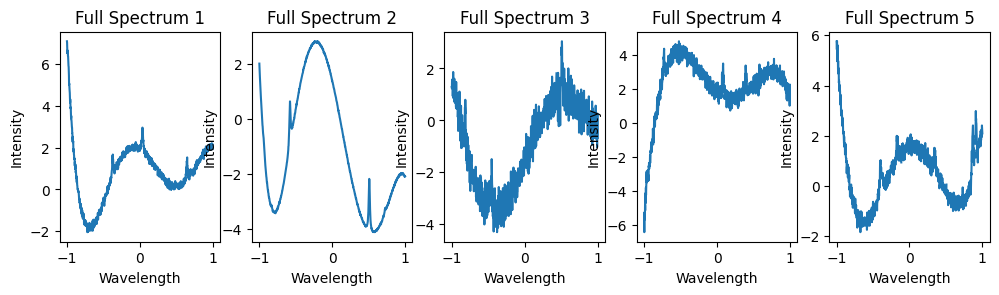

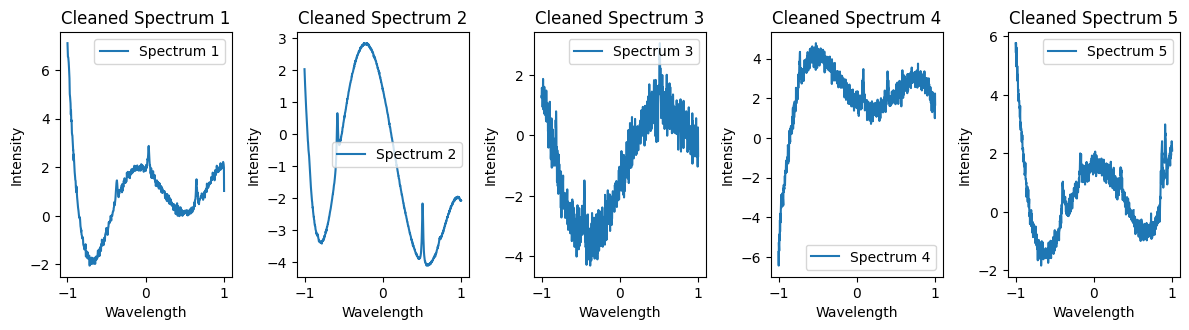

Value at index 1: 0.563698921503927
Value at index 3: 0.15487108550881512
Value at index 4: 0.9686084227801626
Value at index 6: 0.39187047477610637
Value at index 7: 0.20927507964225


In [5]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []


# Cosmic Ray Removal
# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if the spectrum exists in the data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.01
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)
        
        # 3) Replace these points using linear interpolation from neighboring data points
        for index in cosmic_ray_indices:
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.at[index, 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame with a specific filename
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))  # Create a new figure for cleaned spectra
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:5]:  # Print values for the first 5 indices
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices for Spectrum 1: [   1    2    4    6    8   10   12   14   16   17   21   24   28   30
   33   34   36   39   42   44   46   48   50   52   54   56   57   61
   63   65   67   68   70   71   73   74   76   77   80   83   85   86
   88   91   93   95   97   99  102  104  105  107  109  110  114  115
  116  119  121  123  127  129  132  134  137  139  140  143  145  148
  151  153  154  156  158  160  163  165  167  169  171  172  175  176
  178  180  182  184  186  187  189  190  192  194  196  200  203  204
  206  208  211  212  214  217  218  222  223  226  229  231  233  235
  237  238  241  243  245  246  248  250  252  255  257  261  263  264
  267  270  272  275  278  279  283  285  288  290  291  293  294  296
  298  299  300  303  304  307  308  310  312  315  316  318  320  322
  324  326  327  329  331  333  336  337  339  341  343  345  347  349
  350  352  355  358  361  363  365  369  371  374  377  379  381  382
  384  385  386  389  391  392  393  396  

/tmp/ipykernel_19/722705819.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrum_data.at[index, 'Intensity'] = interpolated_value


Cosmic Ray Indices for Spectrum 3: [   0    3    6    8   11   13   15   16   18   19   21   23   25   27
   28   29   31   32   34   35   37   38   41   42   44   46   47   49
   52   54   58   59   60   62   66   68   70   73   75   78   80   81
   83   85   87   89   90   93   95   97  100  105  109  110  113  114
  116  118  121  122  125  129  132  135  141  142  145  146  148  150
  153  154  156  159  160  161  163  165  166  169  173  175  177  183
  185  187  188  190  191  193  195  197  198  201  202  203  205  206
  209  212  214  215  217  220  224  226  228  231  232  233  235  238
  239  240  242  244  246  248  250  252  253  256  258  261  262  266
  268  270  272  273  275  278  281  282  284  287  288  290  292  293
  295  296  298  299  301  303  304  306  308  310  311  314  315  317
  319  321  323  324  325  328  331  332  335  338  340  341  343  344
  346  348  349  351  353  355  357  359  360  364  367  369  370  372
  375  377  379  380  383  384  385  387  

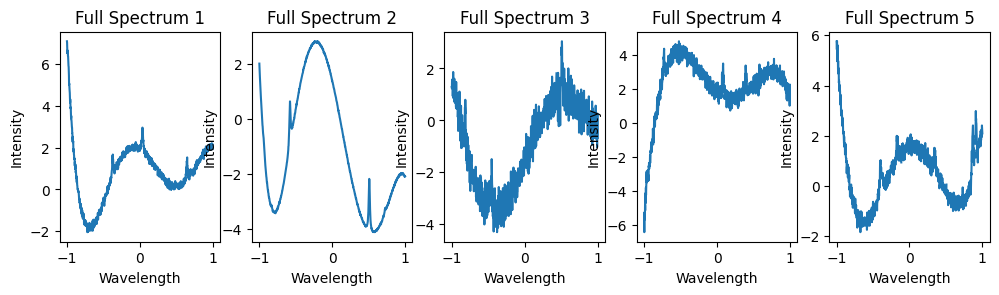

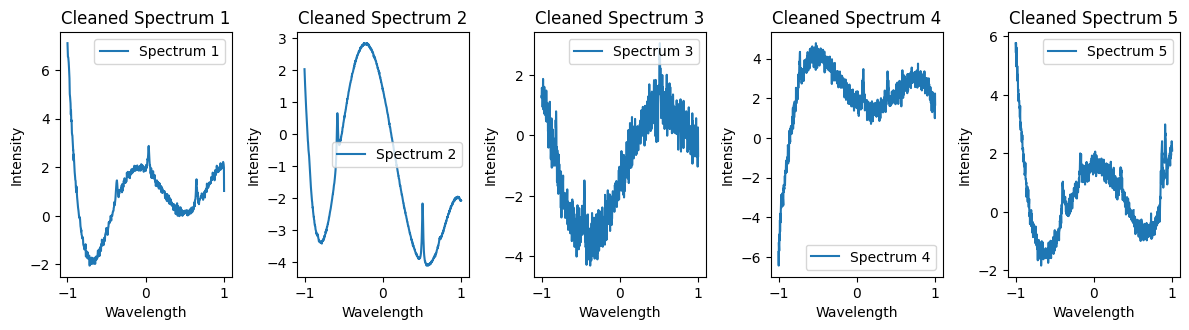

Value at index 1: 0.563698921503927
Value at index 3: 0.15487108550881512
Value at index 4: 0.9686084227801626
Value at index 6: 0.39187047477610637
Value at index 7: 0.20927507964225


In [6]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []


# Cosmic Ray Removal
# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if the spectrum exists in the data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.01
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Weighted average based on distance
            interpolated_value = (left_distance * right_neighbor + right_distance * left_neighbor) / (left_distance + right_distance)
            spectrum_data.at[index, 'Intensity'] = interpolated_value

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.at[index, 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame with a specific filename
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))  # Create a new figure for cleaned spectra
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:5]:  # Print values for the first 5 indices
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")